In [45]:
import numpy as np
import os
import pandas as pd
import keras 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:


(trainX, trainy), (testX, testy) = load_data()

print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)


Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


In [47]:

def build_dis():
    in_label = keras.layers.Input(shape=(1,))
    
    in_label2=keras.layers.Embedding(10,50)(in_label)
    labels_layer1 = keras.layers.Dense(28 * 28)(in_label2)
    labels_layer2 = keras.layers.Reshape((28, 28,1))(labels_layer1)
    
    in_image = keras.layers.Input(shape=(28,28,1))

    merge = keras.layers.Concatenate()([in_image, labels_layer2])


  
    
    l1=merge
    l2=keras.layers.Conv2D(128, (3,3), (2,2), padding="same")(l1)
    l2=keras.layers.LeakyReLU(0.2)(l2)
   
    
    
    l3=keras.layers.Conv2D(128, (3,3), (2,2), padding="same")(l2)
    l3=keras.layers.LeakyReLU(0.2)(l3)
    
   
 
    
    
    
    
    l4=keras.layers.Flatten()(l3)
    l4=keras.layers.Dropout(0.4)(l4)
   
    l_final=keras.layers.Dense(1, activation='sigmoid')(l4)

    dis = keras.Model([in_image, in_label], l_final)
    return dis
################33

dis=build_dis()
from keras.optimizers import Adam
opt = Adam(lr=0.0002, beta_1=0.5)

dis.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [48]:
dis.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 1, 50)        500         input_15[0][0]                   
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 1, 784)       39984       embedding_7[0][0]                
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 28, 28, 1)]  0                                            
______________________________________________________________________________________

In [49]:
def build_generator():
    in_label = keras.layers.Input(shape=(1,))
    in_label2=keras.layers.Embedding(10,50)(in_label)
    label1=keras.layers.Dense(7*7)(in_label2)
    label2=keras.layers.Reshape((7,7,1))(label1)

    
   
    
    

    in_img=keras.layers.Input(shape=(100,))
    img1=keras.layers.Dense(128*7*7)(in_img)
    img1 = keras.layers.LeakyReLU(alpha=0.2)(img1)
    img2=keras.layers.Reshape((7,7,128))(img1)


    merge = keras.layers.Concatenate()([label2,img2 ])

    
    l1=keras.layers.Conv2DTranspose( 128,(4,4), (2,2),padding='same')(merge)
    l1 = keras.layers.LeakyReLU(alpha=0.2)(l1)
    
    
    l2=keras.layers.Conv2DTranspose( 128,(4,4), (2,2),padding='same')(l1)
    l2 = keras.layers.LeakyReLU(alpha=0.2)(l2)
  
    l_final2=keras.layers.Conv2D(1, (7,7), padding="same", activation="tanh")(l2)

    gen = keras.Model([in_img,in_label], l_final2)
    return gen

gen=build_generator()
gen.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 50)        500         input_17[0][0]                   
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 6272)         633472      input_18[0][0]                   
______________________________________________________________________________________

In [50]:
def define_gan(g_model, d_model):
    d_model.trainable = False

    gen_noise, gen_label = g_model.input

    gen_output = g_model.output

    gan_output = d_model([gen_output, gen_label])
    
    model = keras.Model([gen_noise, gen_label], gan_output)
   
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [51]:
gan=define_gan(gen,dis)

In [52]:
def load_real_samples():

    X = np.expand_dims(trainX, axis=-1)

    X = X.astype('float32')
   
    X=(X-127.5)/127.5

    return [X,trainy]


import random
def generate_real_samples(n_samples):

    images, labels = load_real_samples()
 
    ix = random.sample(range(images.shape[0]), n_samples)

    X, labels = images[ix], labels[ix]

    y1 = np.ones((n_samples, 1))
    return [X, labels], y1

In [53]:
generate_real_samples(1)

([array([[[[-1.        ],
           [-1.        ],
           [-1.        ],
           [-1.        ],
           [-1.        ],
           [-1.        ],
           [-1.        ],
           [-1.        ],
           [-1.        ],
           [-1.        ],
           [-1.        ],
           [-1.        ],
           [-1.        ],
           [-1.        ],
           [-1.        ],
           [-1.        ],
           [-1.        ],
           [-1.        ],
           [-1.        ],
           [-1.        ],
           [-1.        ],
           [-1.        ],
           [-1.        ],
           [-1.        ],
           [-1.        ],
           [-1.        ],
           [-1.        ],
           [-1.        ]],
  
          [[-1.        ],
           [-1.        ],
           [-1.        ],
           [-1.        ],
           [-1.        ],
           [-1.        ],
           [-1.        ],
           [-1.        ],
           [-1.        ],
           [-1.        ],
        

In [54]:
def generate_latent_points(latent_dim, n_samples, n_classes=10):

    x_input = np.random.randn(latent_dim * n_samples)

    z_input = x_input.reshape(n_samples, latent_dim)
    
    labels = np.random.randint(0, n_classes, n_samples)
    return [z_input, labels]
 

def generate_fake_samples(generator, latent_dim, n_samples):

    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
 

    images = generator.predict([z_input, labels_input])

    y = np.zeros((n_samples, 1))
    return [images, labels_input], y

In [55]:
data=trainX

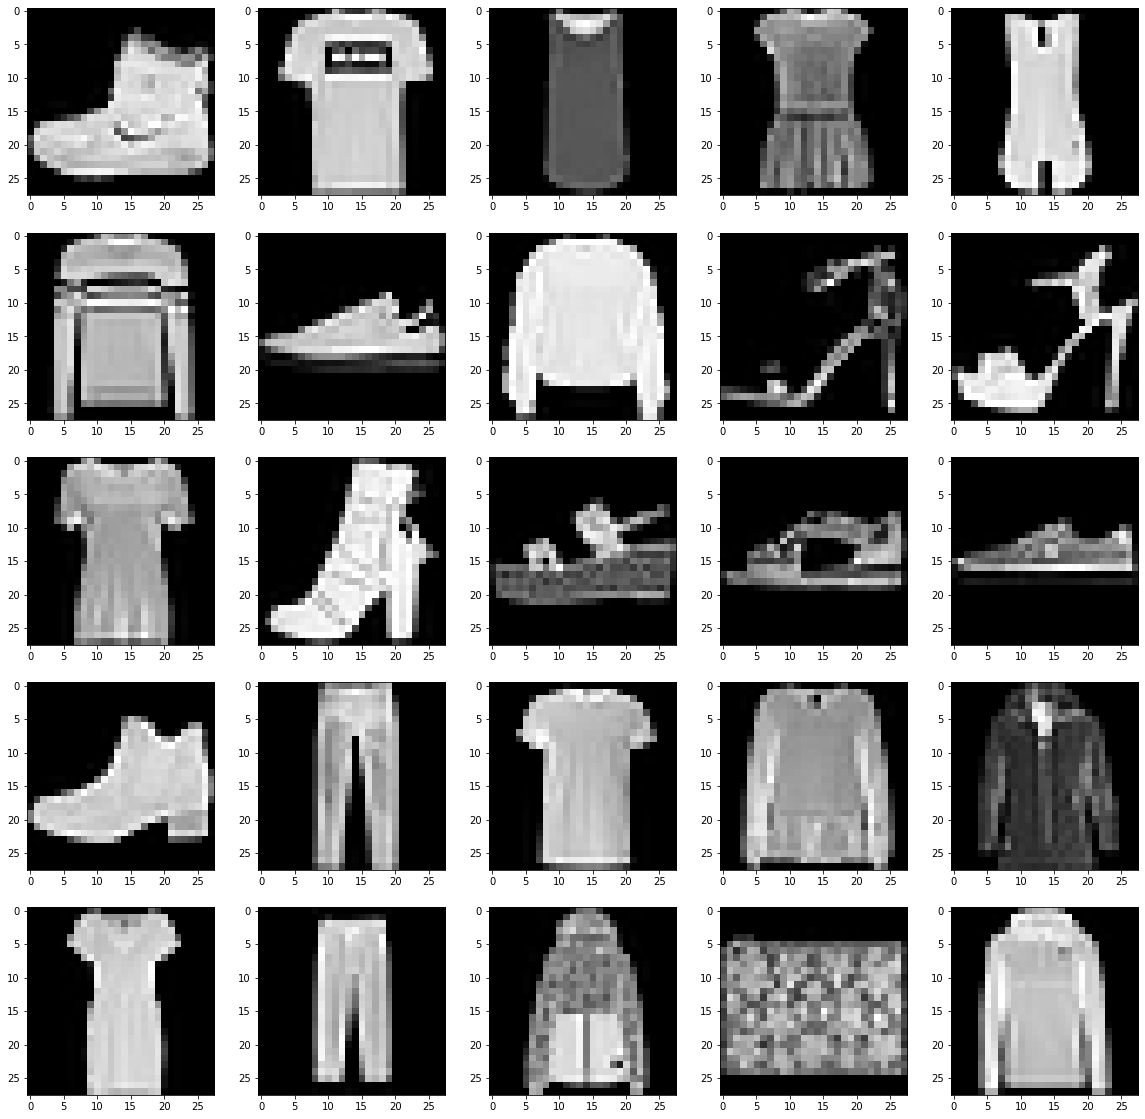

In [56]:
plt.figure(figsize=(20,20))
for i in range (25):
    plt.subplot(5,5,i+1)
    plt.imshow(data[i].reshape((28,28)),cmap='gray')

In [57]:
# train the generator and discriminator
d_1=[]
d_2=[]
ga_=[]
def train(g_model, d_model, gan_model, latent_dim, n_epochs=100, n_batch=128):
    print("here")
    bat_per_epo = int(data.shape[0] / n_batch)
    print(bat_per_epo)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        print("here")
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            print(i+1,j+1)
            # get randomly selected 'real' samples
            [X_real, labels_real], y_real = generate_real_samples( half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            # generate 'fake' examples
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            # prepare points in latent space as input for the generator
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            # summarize loss on this batch
            d_1.append(d_loss1)
            d_2.append(d_loss2)
            ga_.append(g_loss)
        
        if(i%10==0):
            [predictions,_],_ = generate_fake_samples(gen,100,25)
            predictions=np.asarray(predictions)
            plt.figure(figsize=(20,20))
            for it in range(25):
                  plt.subplot(5, 5, it+1)
                  plt.imshow(predictions[it].reshape((28,28)) * 127.5 + 127.5, cmap='gray')
                  plt.axis('off')
            plt.savefig('mnist_image_at_epoch_{:04d}.png'.format(i))
            plt.figure(figsize=(10,10))
            plt.plot(ga_,label='ga_')
            plt.plot(d_1,label='d_1')
            plt.plot(d_2,label='d_2')
            plt.savefig('mnist_graph_at_epoch_{:04d}.png'.format(i))
            plt.legend()
    
    # save the generator model
    



In [58]:
train(gen,dis,gan,100,1)

here
468
here
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11


KeyboardInterrupt: 

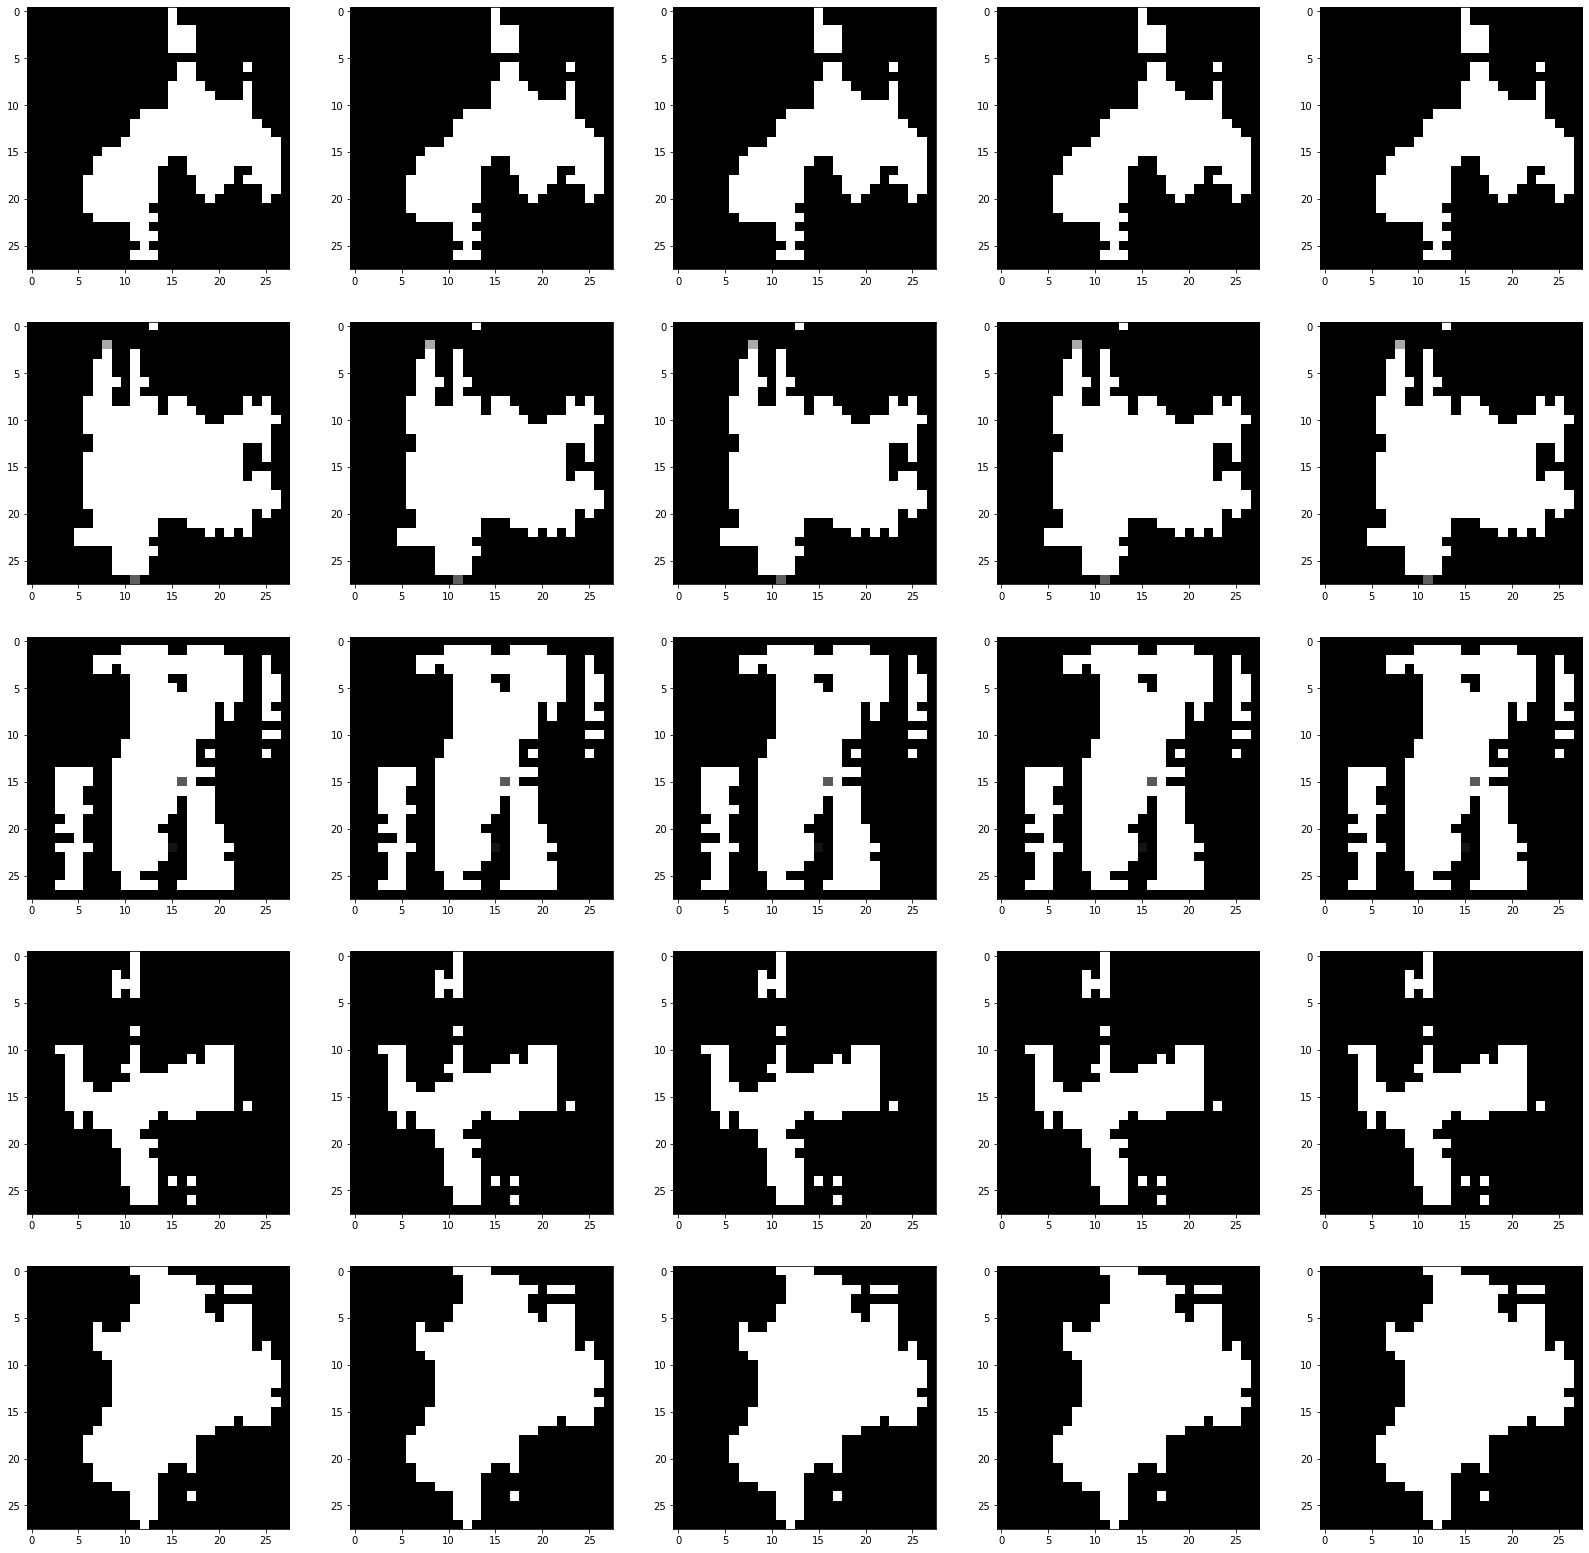

In [31]:
[x,_],_=generate_fake_samples(gen,100,25)
x=np.asarray(x)
x=x.reshape((-1,28,28))

plt.figure(figsize=(28,28))
for i in range(5):
    for j in range(5):
        plt.subplot(5,5,i*5+j+1)
        plt.imshow(x[i] * 127.5 + 127.5,cmap='gray')

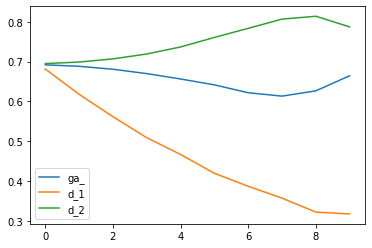

In [59]:
plt.plot(ga_,label='ga_')
plt.plot(d_1,label='d_1')
plt.plot(d_2,label='d_2')
plt.legend()

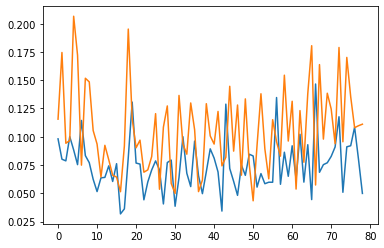

In [33]:
plt.plot(d_2)
plt.plot(d_1)

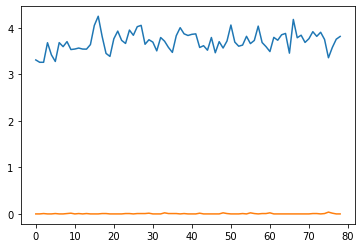

In [34]:
plt.plot(ga_)

In [ ]:
gen.save('mnist_gen.hdf5')

In [ ]:
dis.save('mnist_dis.hdf5')

In [ ]:
gan.save('mnist_gan.hdf5')